# SIEM Stack Project

## Wazuh
---

Wazuh is an Extended Detection and Response (XDR) and SIEM solution that provides comprehensive 
monitoring, detection, and alerting of security events and incidents across multiple layers of the IT 
infrastructure.

Wazuh Provides endpoint security, threat intelligence, and security operations capabilities, enabling proactive 
threat detection, incident response, and regulatory compliance alignment. Benefits include cost effectiveness, strong community support, and multitenancy.

### Wazuh architecture

Wazuh offers agent based and an agentless based approach to monitoring endpoints and devices. Wazuh 
has three main components working together namely; Wazuh indexer, Wazuh manager, and Wazuh 
dashboard. The Wazuh indexer is mainly used for storage and indexing of Logs. The Wazuh manager is 
mainly used as a central server for decoding and analysis of Logs to detect security events. The Wazuh 
dashboard is the visualization tool used to display our security events and our endpoints compliance
information.

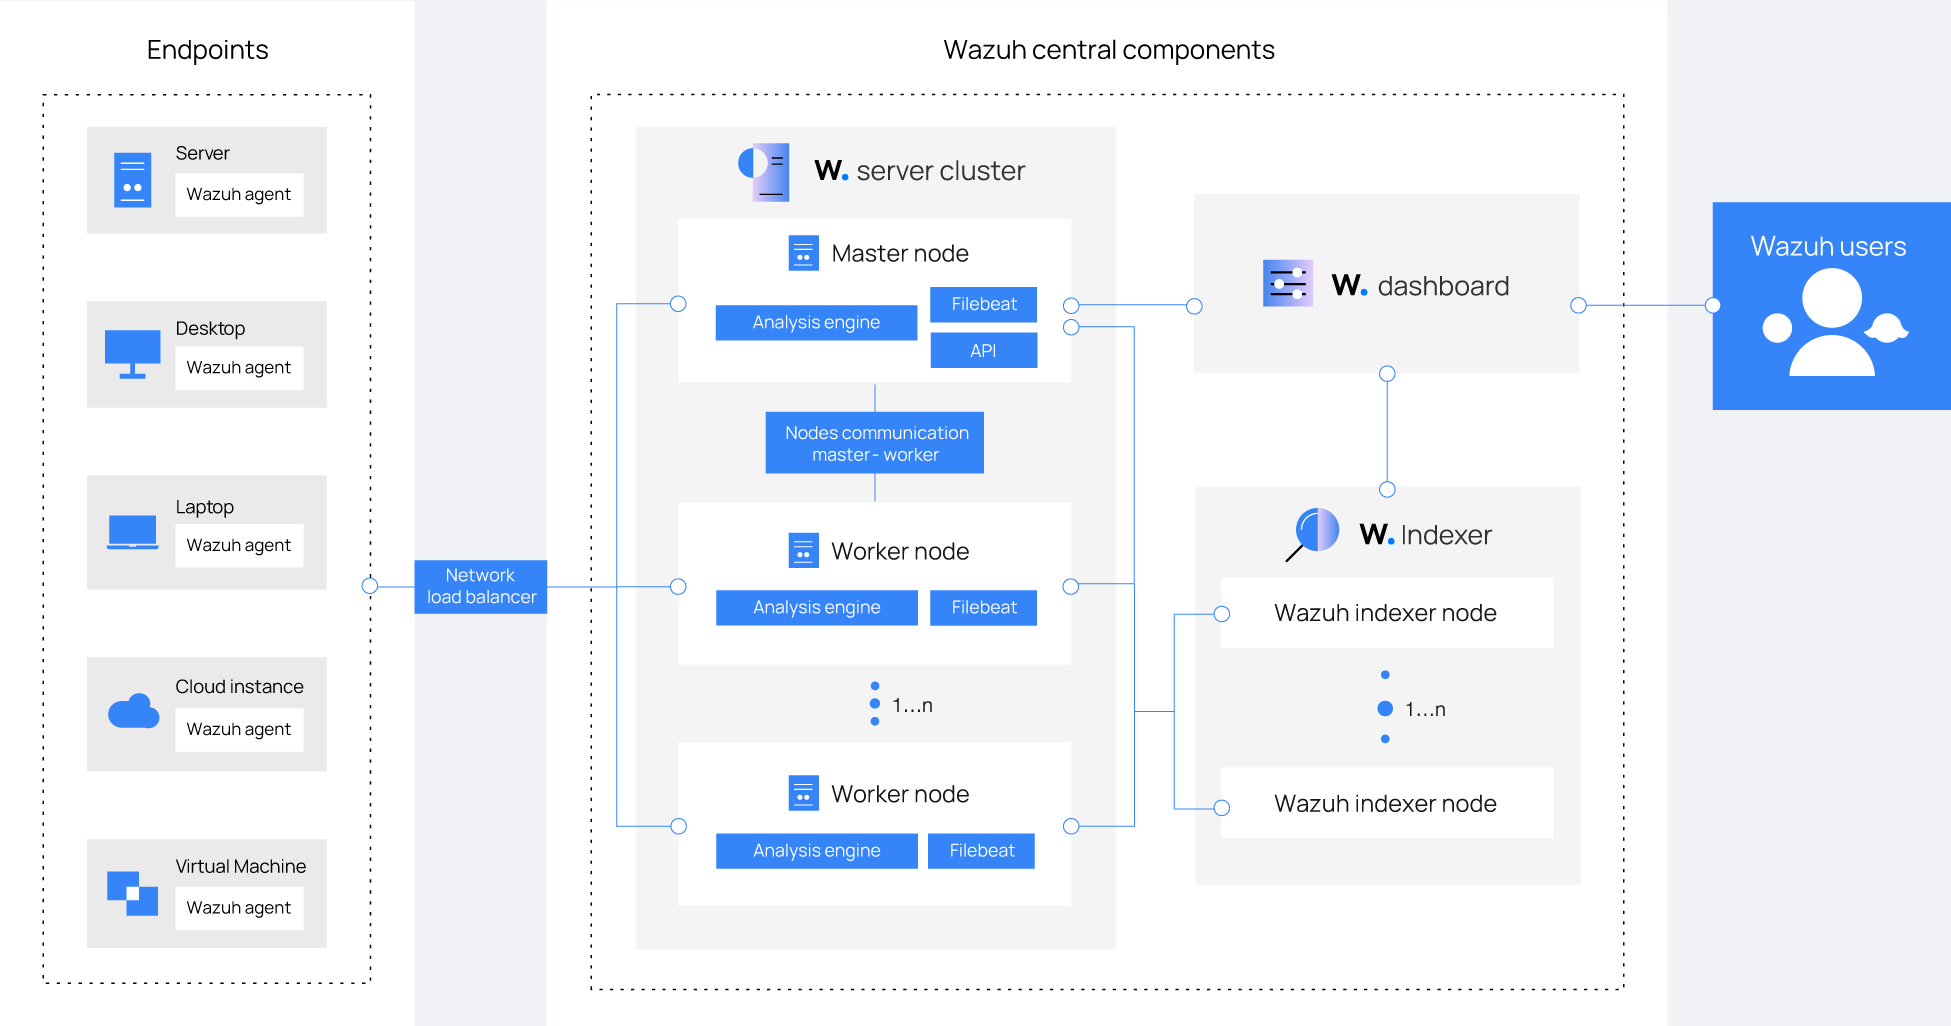
<p><i>Wazuh components architecture</i></p>

### Wazuh requirements

<table>
    <thead>
        <tr>
            <th>Component</th>
            <th>Port</th>
            <th>Protocol</th>
            <th>Purpose</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan="4">Wazuh Server</td>
            <td>1514</td>
            <td>TCP (default)</td>
            <td>Agent connection service</td>
        </tr>
        <tr>
            <td>1515</td>
            <td>TCP</td>
            <td>Agent enrollment service</td>
        </tr>
        <tr>
            <td>1516</td>
            <td>TCP</td>
            <td>Wazuh cluster daemon</td>
        </tr>
        <tr>
            <td>55000</td>
            <td>TCP</td>
            <td>Wazuh server RESTful API</td>
        </tr>
        <tr>
            <td>Wazuh indexer</td>
            <td>9200</td>
            <td>TCP</td>
            <td>Wazuh indexer RESTful API</td>
        </tr>
        <tr>
            <td>Wazuh dashboard</td>
            <td>8443</td>
            <td>TCP</td>
            <td>Wazuh web user interface</td>
        </tr>
    </tbody>
</table>
<p><i>Network ports required</i></p>


|Component|RAM (GB)|CPU (cores)|OS|Storage|
|---:|:---:|:---:|:---:|---:|
|Wazuh indexer|16|8|Ubuntu 22.04|2TB (6 months)|
|Wazuh Manager|16|8|Ubuntu 22.04|20GB|
|Wazuh Dashboard|16|8|Ubuntu 22.04|20GB|
<p><i>Wazuh components requirements</i></p>


|Monitored endpoints|APS (alerts per second)|Storage in Wazuh (GB/90 days)|
|---:|:---:|:---|
|Servers|0.25|3.7|
|Workstations|0.1|1.5|
|Network devices|0.5|7.4|
<p><i>Disk space provisioning estimates</i></p>

### Wazuh 4.8 installation

Note: the installation should be run with root.

#### Install pre-requisites

1. Install the following packages if missing.
```bash
   apt-get install gnupg apt-transport-https
   apt-get install debconf adduser procps
```
2. Install the GPG key.
```bash
   curl -s https://packages.wazuh.com/key/GPG-KEY-WAZUH | gpg --no-default-keyring --keyring gnupg-ring:/usr/share/keyrings/wazuh.gpg --import && chmod 644 /usr/share/keyrings/wazuh.gpg
```
3. Add the repository.
```bash
   echo "deb [signed-by=/usr/share/keyrings/wazuh.gpg] https://packages.wazuh.com/4.x/apt/ stable main" | tee -a /etc/apt/sources.list.d/wazuh.list
```
4. Update the packages information.
```bash
   apt-get update
```

#### Wazuh indexer install

1. Generating the SSL certificates
```bash
   curl -sO https://packages.wazuh.com/4.8/wazuh-certs-tool.sh
   curl -sO https://packages.wazuh.com/4.8/config.yml
```
2. Edit ./config.yml
```yml
    nodes:
    # Wazuh indexer nodes
    indexer:
        - name: wazuh-indexer
        ip: "172.31.30.70"

    # Wazuh server nodes
    # If there is more than one Wazuh server
    # node, each one must have a node_type
    server:
        - name: wazuh-server
        ip: "172.31.30.70"
        #  node_type: master
        #- name: wazuh-2
        #  ip: "<wazuh-manager-ip>"
        #  node_type: worker
        #- name: wazuh-3

    # Wazuh dashboard nodes
    dashboard:
        - name: wazuh-dashboard
        ip: "172.31.30.70"
```
3. Run ./wazuh-certs-tool.sh to create the certificates
```bash
   bash ./wazuh-certs-tool.sh -A
```
4. Compress all the necessary files
```bash
   tar -cvf ./wazuh-certificates.tar -C ./wazuh-certificates/ .
   rm -rf ./wazuh-certificates
```
5. Install the Wazuh indexer package
```bash
   apt-get -y install wazuh-indexer
```
6. Edit the /etc/wazuh-indexer/opensearch.yml configuration
```yml
    network.host: "0.0.0.0"
    node.name: "wazuh-indexer"
    cluster.initial_master_nodes:
    - "wazuh-indexer"
    #- "node-2"
    cluster.name: "wazuh-cluster"
    #discovery.seed_hosts:
    #  - "node-1-ip"
    node.max_local_storage_nodes: "3"
    path.data: /var/lib/wazuh-indexer
    path.logs: /var/log/wazuh-indexer

    plugins.security.ssl.http.pemcert_filepath: /etc/wazuh-indexer/certs/indexer.pem
    plugins.security.ssl.http.pemkey_filepath: /etc/wazuh-indexer/certs/indexer-key.pem
    plugins.security.ssl.http.pemtrustedcas_filepath: /etc/wazuh-indexer/certs/root-ca.pem
    plugins.security.ssl.transport.pemcert_filepath: /etc/wazuh-indexer/certs/indexer.pem
    plugins.security.ssl.transport.pemkey_filepath: /etc/wazuh-indexer/certs/indexer-key.pem
    plugins.security.ssl.transport.pemtrustedcas_filepath: /etc/wazuh-indexer/certs/root-ca.pem
    plugins.security.ssl.http.enabled: true
    plugins.security.ssl.transport.enforce_hostname_verification: false
    plugins.security.ssl.transport.resolve_hostname: false

    plugins.security.authcz.admin_dn:
    - "CN=admin,OU=Wazuh,O=Wazuh,L=California,C=US"
    plugins.security.check_snapshot_restore_write_privileges: true
    plugins.security.enable_snapshot_restore_privilege: true
    plugins.security.nodes_dn:
    - "CN=wazuh-indexer,OU=Wazuh,O=Wazuh,L=California,C=US"
    plugins.security.restapi.roles_enabled:
    - "all_access"
    - "security_rest_api_access"

    plugins.security.system_indices.enabled: true
    plugins.security.system_indices.indices: [".plugins-ml-model", ".plugins-ml-task", ".opendistro-alerting-config", ".opendistro-alerting-alert*", ".opendistro-anomaly-results*", ".opendistro-anomaly-detector*", ".opendistro-anomaly-checkpoints", ".opendistro-anomaly-detection-state", ".opendistro-reports-*", ".opensearch-notifications-*", ".opensearch-notebooks", ".opensearch-observability", ".opendistro-asynchronous-search-response*", ".replication-metadata-store"]

    ### Option to allow Filebeat-oss 7.10.2 to work ###
    compatibility.override_main_response_version: true
```
7. Deploying certificates
```bash
   NODE_NAME=indexer
   mkdir /etc/wazuh-indexer/certs
   tar -xf ./wazuh-certificates.tar -C /etc/wazuh-indexer/certs/ ./$NODE_NAME.pem ./$NODE_NAME-key.pem ./admin.pem ./admin-key.pem ./root-ca.pem
   mv -n /etc/wazuh-indexer/certs/$NODE_NAME.pem /etc/wazuh-indexer/certs/indexer.pem
   mv -n /etc/wazuh-indexer/certs/$NODE_NAME-key.pem /etc/wazuh-indexer/certs/indexer-key.pem
   chmod 500 /etc/wazuh-indexer/certs
   chmod 400 /etc/wazuh-indexer/certs/*
   chown -R wazuh-indexer:wazuh-indexer /etc/wazuh-indexer/certs
```
8. Starting the service
```bash
   systemctl daemon-reload
   systemctl enable wazuh-indexer
   systemctl start wazuh-indexer
```
9. Cluster initialization
```bash
   /usr/share/wazuh-indexer/bin/indexer-security-init.sh
```
10. Testing the cluster installation
```bash
   curl -k -u admin:admin https://172.31.30.70:9200
   curl -k -u admin:admin https://172.31.30.70:9200/_cat/nodes?v
```

#### Wazuh manager install

1. Install the Wazuh manager package
```bash
   apt-get -y install wazuh-manager
```
2. Save the Wazuh indexer username and password into the Wazuh manager keystore using the wazuh-keystore tool
```bash
   /var/ossec/bin/wazuh-keystore -f indexer -k username -v admin
   /var/ossec/bin/wazuh-keystore -f indexer -k password -v admin
```
3. Edit /var/ossec/etc/ossec.conf to configure the indexer connection
```xml
    <indexer>
        <enabled>yes</enabled>
        <hosts>
            <host>https://172.31.30.70:9200</host>
        </hosts>
        <ssl>
            <certificate_authorities>
                <ca>/etc/filebeat/certs/root-ca.pem</ca>
            </certificate_authorities>
            <certificate>/etc/filebeat/certs/filebeat.pem</certificate>
            <key>/etc/filebeat/certs/filebeat-key.pem</key>
        </ssl>
    </indexer>
```

#### Filebeat install

1. Install the Filebeat package
```bash
   apt-get -y install filebeat
```
2. Download the preconfigured Filebeat configuration file
```bash
   curl -so /etc/filebeat/filebeat.yml https://packages.wazuh.com/4.8/tpl/wazuh/filebeat/filebeat.yml
```
3. Edit the /etc/filebeat/filebeat.yml configuration
```yml
   # Wazuh - Filebeat configuration file
   output.elasticsearch:
   hosts: ["172.31.30.70:9200"]
   protocol: https
   username: ${username}
   password: ${password}
   ssl.certificate_authorities:
      - /etc/filebeat/certs/root-ca.pem
   ssl.certificate: "/etc/filebeat/certs/filebeat.pem"
   ssl.key: "/etc/filebeat/certs/filebeat-key.pem"
   setup.template.json.enabled: true
   setup.template.json.path: '/etc/filebeat/wazuh-template.json'
   setup.template.json.name: 'wazuh'
   setup.ilm.overwrite: true
   setup.ilm.enabled: false

   filebeat.modules:
   - module: wazuh
      alerts:
         enabled: true
      archives:
         enabled: false

   logging.level: info
   logging.to_files: true
   logging.files:
   path: /var/log/filebeat
   name: filebeat
   keepfiles: 7
   permissions: 0644

   logging.metrics.enabled: false

   seccomp:
   default_action: allow
   syscalls:
   - action: allow
      names:
      - rseq
```
4. Create a Filebeat keystore to securely store authentication credentials
```bash
   filebeat keystore create
```
5. Add the default username and password admin:admin to the secrets keystore
```bash
   echo admin | filebeat keystore add username --stdin --force
   echo admin | filebeat keystore add password --stdin --force
```
6. Download the alerts template for the Wazuh indexer
```bash
   curl -so /etc/filebeat/wazuh-template.json https://raw.githubusercontent.com/wazuh/wazuh/v4.8.0/extensions/elasticsearch/7.x/wazuh-template.json
   chmod go+r /etc/filebeat/wazuh-template.json
```
7. Install the Wazuh module for Filebeat
```bash
   curl -s https://packages.wazuh.com/4.x/filebeat/wazuh-filebeat-0.4.tar.gz | tar -xvz -C /usr/share/filebeat/module
```
8. Deploying certificate
```bash
   NODE_NAME=filebeat
   mkdir /etc/filebeat/certs
   tar -xf ./wazuh-certificates.tar -C /etc/filebeat/certs/ ./$NODE_NAME.pem ./$NODE_NAME-key.pem ./root-ca.pem
   mv -n /etc/filebeat/certs/$NODE_NAME.pem /etc/filebeat/certs/filebeat.pem
   mv -n /etc/filebeat/certs/$NODE_NAME-key.pem /etc/filebeat/certs/filebeat-key.pem
   chmod 500 /etc/filebeat/certs
   chmod 400 /etc/filebeat/certs/*
   chown -R root:root /etc/filebeat/certs
```

#### Wazuh dashbard install

1. Install the Wazuh dashboard package
```bash
   apt-get -y install wazuh-dashboard
```
2. Edit the /etc/wazuh-dashboard/opensearch_dashboards.yml
```yml
    server.host: 0.0.0.0
    server.port: 8443
    opensearch.hosts: https://wazuh_dashboard_IP:9200
    opensearch.ssl.verificationMode: certificate
    #opensearch.username:
    #opensearch.password:
    opensearch.requestHeadersAllowlist: ["securitytenant","Authorization"]
    opensearch_security.multitenancy.enabled: true
    opensearch_security.multitenancy.tenants.preferred: ["Global", "Private"]
    opensearch_security.readonly_mode.roles: ["kibana_read_only"]
    server.ssl.enabled: true
    server.ssl.key: "/etc/wazuh-dashboard/certs/dashboard-key.pem"
    server.ssl.certificate: "/etc/wazuh-dashboard/certs/dashboard.pem"
    opensearch.ssl.certificateAuthorities: ["/etc/wazuh-dashboard/certs/root-ca.pem"]
    uiSettings.overrides.defaultRoute: /app/wz-home
```
3. Deploying certificates
```bash
    NODE_NAME=dashboard
    mkdir /etc/wazuh-dashboard/certs
    tar -xf ./wazuh-certificates.tar -C /etc/wazuh-dashboard/certs/ ./$NODE_NAME.pem ./$NODE_NAME-key.pem ./root-ca.pem
    mv -n /etc/wazuh-dashboard/certs/$NODE_NAME.pem /etc/wazuh-dashboard/certs/dashboard.pem
    mv -n /etc/wazuh-dashboard/certs/$NODE_NAME-key.pem /etc/wazuh-dashboard/certs/dashboard-key.pem
    chmod 500 /etc/wazuh-dashboard/certs
    chmod 400 /etc/wazuh-dashboard/certs/*
    chown -R wazuh-dashboard:wazuh-dashboard /etc/wazuh-dashboard/certs
```
4. Start service
```bash
   systemctl daemon-reload
   systemctl enable wazuh-dashboard
   systemctl start wazuh-dashboard
```
5. Edit the /usr/share/wazuh-dashboard/data/wazuh/config/wazuh.yml
```yml
    hosts:
    - default:
        url: https://localhost
        port: 55000
        username: wazuh-wui
        password: wazuh-wui
        run_as: true


```

### Securing Wazuh installation

1. Use the Wazuh passwords tool to change all the internal users' passwords
```bash
    /usr/share/wazuh-indexer/plugins/opensearch-security/tools/wazuh-passwords-tool.sh --change-all --admin-user wazuh --admin-password wazuh
```
2. output 
```bash
    INFO: The password for user admin is yWOzmNA.?Aoc+rQfDBcF71KZp?1xd7IO
    INFO: The password for user kibanaserver is nUa+66zY.eDF*2rRl5GKdgLxvgYQA+wo
    INFO: The password for user kibanaro is 0jHq.4i*VAgclnqFiXvZ5gtQq1D5LCcL
    INFO: The password for user logstash is hWW6U45rPoCT?oR.r.Baw2qaWz2iH8Ml
    INFO: The password for user readall is PNt5K+FpKDMO2TlxJ6Opb2D0mYl*I7FQ
    INFO: The password for user snapshotrestore is +GGz2noZZr2qVUK7xbtqjUup049tvLq.
    WARNING: Wazuh indexer passwords changed. Remember to update the password in the Wazuh dashboard and Filebeat nodes if necessary, and restart the services.
    INFO: The password for Wazuh API user wazuh is JYWz5Zdb3Yq+uOzOPyUU4oat0n60VmWI
    INFO: The password for Wazuh API user wazuh-wui is +fLddaCiZePxh24*?jC0nyNmgMGCKE+2
    INFO: Updated wazuh-wui user password in wazuh dashboard. Remember to restart the service.
```

### Wazuh 4.8 upgrade

1. stop all the service 
```bash
   systemctl stop wazuh-manager
   systemctl stop wazuh-dashboard
   systemctl stop wazuh-indexer
```

2. upgrade the wazuh indexer
```bash
   sudo apt-get install --only-upgrade wazuh-indexer
```
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;start the wazuh indexer
```bash
   systemctl start wazuh-indexer
   systemctl status wazuh-indexer
```

3. upgrade the wazuh dashboard
```bash
   sudo apt-get install --only-upgrade wazuh-dashboard
```
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;start the wazuh dashboard
```bash
   systemctl start wazuh-dashboard
   systemctl status wazuh-dashboard
```

4. upgrade the wazuh manager
```bash
   sudo apt-get install --only-upgrade wazuh-manager
```
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;start the wazuh manager
```bash
   systemctl start wazuh-manager
   systemctl status wazuh-manager
```

5. update ossec configuration
Edit your ossec.conf file to update the vulnerability detection configuration. Replace the existing `<vulnerability-detector>` block with the new configuration

```xml
   <vulnerability-detection>
      <enabled>yes</enabled>
      <index-status>yes</index-status>
      <feed-update-interval>60m</feed-update-interval>
   </vulnerability-detection>

   <indexer>
      <enabled>yes</enabled>
      <hosts>
         <host>https://0.0.0.0:9200</host>
      </hosts>
      <ssl>
         <certificate_authorities>
            <ca>/etc/filebeat/certs/root-ca.pem</ca>
         </certificate_authorities>
         <certificate>/etc/filebeat/certs/filebeat.pem</certificate>
         <key>/etc/filebeat/certs/filebeat-key.pem</key>
      </ssl>
   </indexer>
```
<p><i>code to insert in ossec.conf on the wazuh manager</i></p>

### Socfortress advanced rules integration

1. clone Socfortress wazuh advanced rules
```bash
   git clone https://github.com/socfortress/Wazuh-Rules.git
```
2. execute Socfortress advanced rules setup script
```bash
   sudo sh wazuh_socfortress_rules.sh
```

### Browser downloads integration

1. local_rules configuration
```xml
   <group name="downloads">
      <rule id="900702" level="5">
        <field name="rule.groups">downloads</field>
        <field name="rule.level">5</field>
        <description>Browser download - $(path)</description>
      </rule>
   </group>
```
2. windows group agent.conf configuration
```xml
   <agent_config><localfile>
      <location>C:\Users\*\AppData\Local\Google\Chrome\User Data\Default\chrome_history.json</location>
         <log_format>json</log_format>
      </localfile>
      <localfile>
         <location>C:\Users\*\AppData\Local\Microsoft\Edge\User Data\Default\edge_history.json</location>
         <log_format>json</log_format>
      </localfile>
      <localfile>
         <location>C:\Users\*\AppData\Roaming\Mozilla\Firefox\Profiles\*.default-release\mozilla_history.json</location>
         <log_format>json</log_format>
      </localfile>
   </agent_config>
```
3. Use Task scheduler to run chrome_history,edge_history,mozilla_history binaries through vbscript -> powershell -> binary

### Sophos integration

1. Sophos siem script
```bash
   git clone https://github.com/sophos/Sophos-Central-SIEM-Integration.git 
   mv Sophos-Central-SIEM-Integration/ /opt/Sophos-Central-SIEM-Integration/
```
2. Sophos pull script 
```bash
   cd /opt/Sophos-Central-SIEM-Integration/ && /usr/bin/python3 siem.py
```
3. Ossec configuration
```xml
   <wodle name="command">
     <disabled>no</disabled>
     <tag>Sophos</tag>
     <command>/var/ossec/etc/sophos_pull.sh</command>
     <interval>5m</interval>
     <run_on_start>yes</run_on_start>
   </wodle>

   <localfile>
     <log_format>json</log_format>
     <location>/opt/Sophos-Central-SIEM-Integration/log/result.json</location>
   </localfile>
```

### DFIR IRIS integration

1. custom DFIR IRIS script
```python
    #!/usr/bin/env python3
    # custom-iris.py
    # Custom Wazuh integration script to send alerts to DFIR-IRIS

    import sys
    import json
    import requests
    from requests.auth import HTTPBasicAuth

    # Function to create a formatted string from alert details
    def format_alert_details(alert_json):
        rule = alert_json.get("rule", {})
        agent = alert_json.get("agent", {})
        
        # Extracting MITRE information from the nested 'rule' structure
        mitre = rule.get("mitre", {})
        mitre_ids = ', '.join(mitre.get("id", ["N/A"]))
        mitre_tactics = ', '.join(mitre.get("tactic", ["N/A"]))
        mitre_techniques = ', '.join(mitre.get("technique", ["N/A"]))

        details = [
            f"Rule ID: {rule.get('id', 'N/A')}",
            f"Rule Level: {rule.get('level', 'N/A')}",
            f"Rule Description: {rule.get('description', 'N/A')}",
            f"Agent ID: {agent.get('id', 'N/A')}",
            f"Agent Name: {agent.get('name', 'N/A')}",
            f"MITRE IDs: {mitre_ids}",
            f"MITRE Tactics: {mitre_tactics}",
            f"MITRE Techniques: {mitre_techniques}",
            f"Location: {alert_json.get('location', 'N/A')}",
            f"Full Log: {alert_json.get('full_log', 'N/A')}"
        ]
        return '\n'.join(details)

    # Read parameters when integration is run
    alert_file = sys.argv[1]
    api_key = sys.argv[2]
    hook_url = sys.argv[3]

    # Read the alert file
    with open(alert_file) as f:
        alert_json = json.load(f)

    # Prepare alert details
    alert_details = format_alert_details(alert_json)

    # Convert Wazuh rule levels(0-15) -> IRIS severity(1-6)
    alert_level = alert_json.get("rule", {}).get("level") 
    if(alert_level < 5):
        severity = 2
    elif(alert_level >= 5 and alert_level < 7):
        severity = 3
    elif(alert_level >= 7 and alert_level < 10):
        severity = 4
    elif(alert_level >= 10 and alert_level < 13):
        severity = 5
    elif(alert_level >= 13):
        severity = 6
    else:
        severity = 1

    # Generate request
    # Reference: https://docs.dfir-iris.org/_static/iris_api_reference_v2.0.1.html#tag/Alerts/operation/post-case-add-alert
    payload = json.dumps({
        "alert_title": alert_json.get("rule", {}).get("description", "No Description"),
        "alert_description": alert_details,
        "alert_source": "Wazuh",
        "alert_source_ref": alert_json.get("id", "Unknown ID"),
        "alert_source_link": "https://172.31.30.70:8443/app/wazuh",  # Replace with actual Wazuh URL
        "alert_severity_id": severity,
        "alert_status_id": 2,  # 'New' status
        "alert_source_event_time": alert_json.get("timestamp", "Unknown Timestamp"),
        "alert_note": "",
        "alert_tags": f"wazuh,{alert_json.get('agent', {}).get('name', 'N/A')}",
        "alert_customer_id": 2,  # '1' for default 'IrisInitialClient'
        "alert_source_content": alert_json  # raw log
    })

    # Send request to IRIS
    response = requests.post(hook_url,verify=False, data=payload, headers={"Authorization": "Bearer " + api_key, "content-type": "application/json"})

    sys.exit(0)

```
2. Ossec configuration
```xml
   <integration>
      <name>custom-iris.py</name>
      <hook_url>http://127.0.0.1:8000/alerts/add</hook_url>
      <level>7</level>
      <api_key>insert key</api_key>
      <alert_format>json</alert_format>
   </integration>
```


### Wazuh Multitenancy

#### Enabling Multitenancy

1. Edit the /etc/wazuh-dashboard/opensearch_dashboards.yml
```yml
   opensearch_security.multitenancy.enabled: true
   opensearch_security.multitenancy.tenants.preferred: ["Global", "Private"]
   uiSettings.overrides.defaultRoute: /app/wz-home?security_tenant=private
```
2. Restart the Wazuh dashboard
```bash
   systemctl restart wazuh-dashboard
``` 

#### Creating tenants

## Grafana
---

Grafana is a visualization tool which provides us with the capabilities to create custom Dashboards for our SIEM. It provides us with a data connection feature which helps us to integrate data from any data source and build dashboards with its vast visualization panels.

### Install pre-requisites

1. Install the prerequisite packages
```bash
   sudo apt-get install -y apt-transport-https software-properties-common wget
```
2. Import the GPG key
```bash
   sudo mkdir -p /etc/apt/keyrings/
   wget -q -O - https://apt.grafana.com/gpg.key | gpg --dearmor | sudo tee /etc/apt/keyrings/grafana.gpg > /dev/null
```
3. To add a repository for stable releases, run the following command
```bash
   echo "deb [signed-by=/etc/apt/keyrings/grafana.gpg] https://apt.grafana.com stable main" | sudo tee -a /etc/apt/sources.list.d/grafana.list
```
4. update the list of available packages
```bash
   sudo apt-get update
```

### Grafana installation

1. To install Grafana OSS (opensource)
```bash
   sudo apt-get install grafana
```
2. To install Grafana Enterprise
```bash
   sudo apt-get install grafana-enterprise
```
3. To start the service
```bash
   sudo systemctl daemon-reload
   sudo systemctl start grafana-server
   sudo systemctl status grafana-server
```
4. To configure the Grafana server to start at boot
```bash
   sudo systemctl enable grafana-server.service
```

### Grafana upgrade

#### Backup Grafana Configuration

Copy Grafana configuration files that you might have modified in your Grafana deployment to a backup directory.
* Default configuration: `$WORKING_DIR/defaults.ini` (Don’t change this file)
* Custom configuration: `$WORKING_DIR/custom.ini`

#### Backup Grafana plugin

Installing plugins in Grafana creates a folder for each plugin with its associated files and data. Copy all files and folders recursively from this location to your backup repository.
* Default location for plugins in a binary or source installation: `$WORKING_DIR/data/plugins`
* Default location for plugins in a deb or rpm package: `/var/lib/grafana/plugins`. This path is specified in the Grafana init.d script using `--config` file parameter

#### Backup Grafana database

1. postgres backup 
```bash
   backup:
   > pg_dump grafana > grafana_backup

   restore:
   > psql grafana < grafana_backup
```
2. mysql backup
```bash
   backup:
   > mysqldump -u root -p[root_password] [grafana] > grafana_backup.sql

   restore:
   > mysql -u root -p grafana < grafana_backup.sql
```
3. The default Grafana database is SQLite, which stores its data in a single file on disk. To back up this file, copy it to your backup repository.

NOTE

To ensure data integrity, shut down your Grafana service before backing up the SQLite database.
The SQLite database file is located in one of the following directories:

Default location for SQLite data in a binary or source installation: `$WORKING_DIR/data/grafana.db`
Default location for SQLite data in a deb or rpm package: `/var/lib/grafana/grafana.db`. This path is specified in the Grafana init.d script using `--config` file parameter

#### Upgrade Grafana

1. In your current installation of Grafana, save your custom configuration changes to a file named <grafana_install_dir>/grafana.ini
2. Run the following commands
```bash
   sudo apt-get update
   sudo apt-get upgrade
```

### Grafana plugin installation

1. Netsage sankey panel
```bash
   grafana-cli plugins install netsage-sankey-panel
```
2. infinity data connector
```bash
   grafana-cli plugins install yesoreyeram-infinity-datasource
```
3. speakyourcode button panel
```bash
   grafana-cli plugins install speakyourcode-button-panel
```
4. data manipulation panel
```bash
   grafana-cli plugins install volkovlabs-form-panel
```
5. cloudspout button panel
```bash
   grafana-cli --pluginUrl https://github.com/cloudspout/cloudspout-button-panel/releases/download/7.0.23/cloudspout-button-panel.zip \
   plugins install cloudspout-button-panel
``` 

### Infinity plugin with speakyourcode button panel

#### implementing action panel

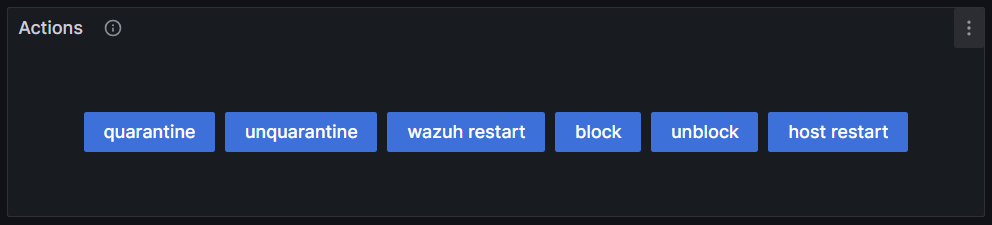
```html
action panel
```
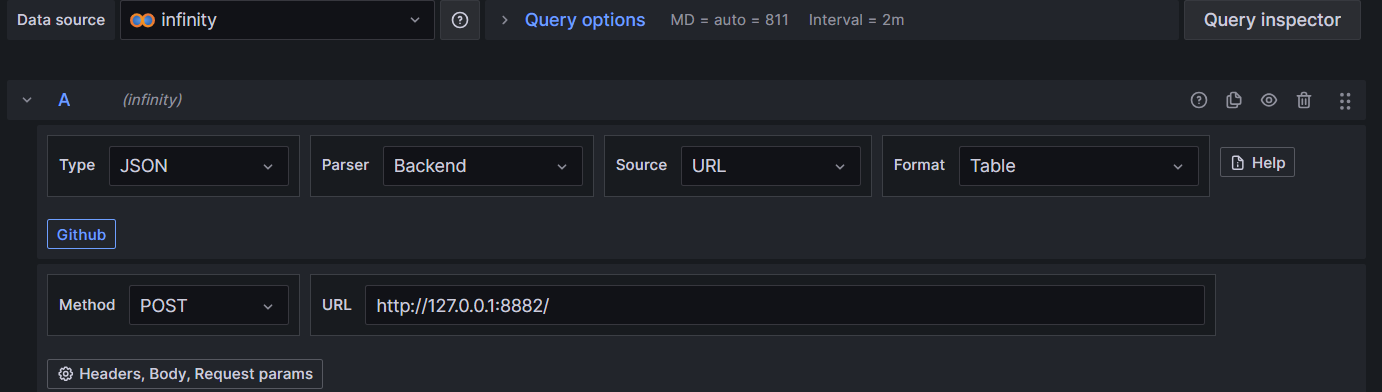
```html
data connector
```
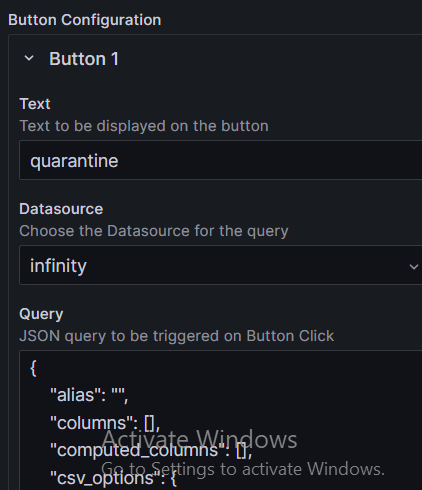
```html
button configuration
```


Query to insert

```json
{
    "alias": "",
    "columns": [],
    "computed_columns": [],
    "csv_options": {
    "columns": "",
    "comment": "",
    "delimiter": "",
    "relax_column_count": false,
    "skip_empty_lines": false,
    "skip_lines_with_error": false
    },
    "data": "",
    "dataOverrides": null,
    "expression": "",
    "filterExpression": "",
    "filters": [],
    "format": "table",
    "global_query_id": "",
    "groq": "",
    "json_options": {
    "columnar": false,
    "root_is_not_array": false
    },
    "parser": "backend",
    "query_mode": "",
    "refId": "A",
    "root_selector": "",
    "seriesCount": 0,
    "source": "url",
    "sqlite_query": "",
    "summarizeBy": "",
    "summarizeExpression": "",
    "type": "json",
    "uql": "",
    "url": "http://127.0.0.1:8882/",
    "url_options": {
    "body_content_type": "application/json",
    "body_form": null,
    "body_graphql_query": "",
    "body_graphql_variables": "",
    "body_type": "raw",
    "data": "{\r\n  \"hosts\":\"${hostname}\",\r\n\"action\":\"c2d66755e6d0b42f7a54187c020f4c80f779620a057c070c779007da6b851f5d\"\r\n}",
    "headers": [],
    "method": "POST",
    "params": null
    }
}
```

### Grafana Multitenancy

## DFIR IRIS
---

IRIS is a collaborative platform aiming to help incident responders to share technical details during investigations.
It's free and open-source

### DFIR IRIS installation

1. Clone the iris-web repository
```bash
   git clone https://github.com/dfir-iris/iris-web.git
   cd iris-web
```
2. Check out the latest non-beta tagged version
```bash
   git checkout v2.3.7
```
3. Copy the environment file
```bash
   cp .env.model .env
```

### Configuring DFIR IRIS

The following secrets in the .env need to be changed for production.
We recommend using OpenSSL to generate different values from each secret:
`openssl rand -base64 64`
1. `POSTGRES_PASSWORD`: Password of the postgres user
2. `POSTGRES_ADMIN_PASSWORD`: Password of the db admin user
3. `IRIS_SECRET_KEY`: Key used by Flask to secure the session cookies
4. `IRIS_SECURITY_PASSWORD_SALT`: A salt used for password encryption in the DB
5. `IRIS_ADM_PASSWORD`: Password of the administrator account. The password need to match the default password policy
6. `IRIS_ADM_API_KEY`: API key of the administrator. A random long string. No verification for the complexity is done.

### Build DFIR IRIS

1. Build the Docker containers
```bash
   docker-compose build
```
2. Start IRIS
```bash
   docker-compose up
```

### DFIR IRIS Multitenancy

## Velociraptor
---

Velociraptor is an advanced digital forensic and incident response tool that enhances your visibility into your endpoints.

### Velociraptor architecture

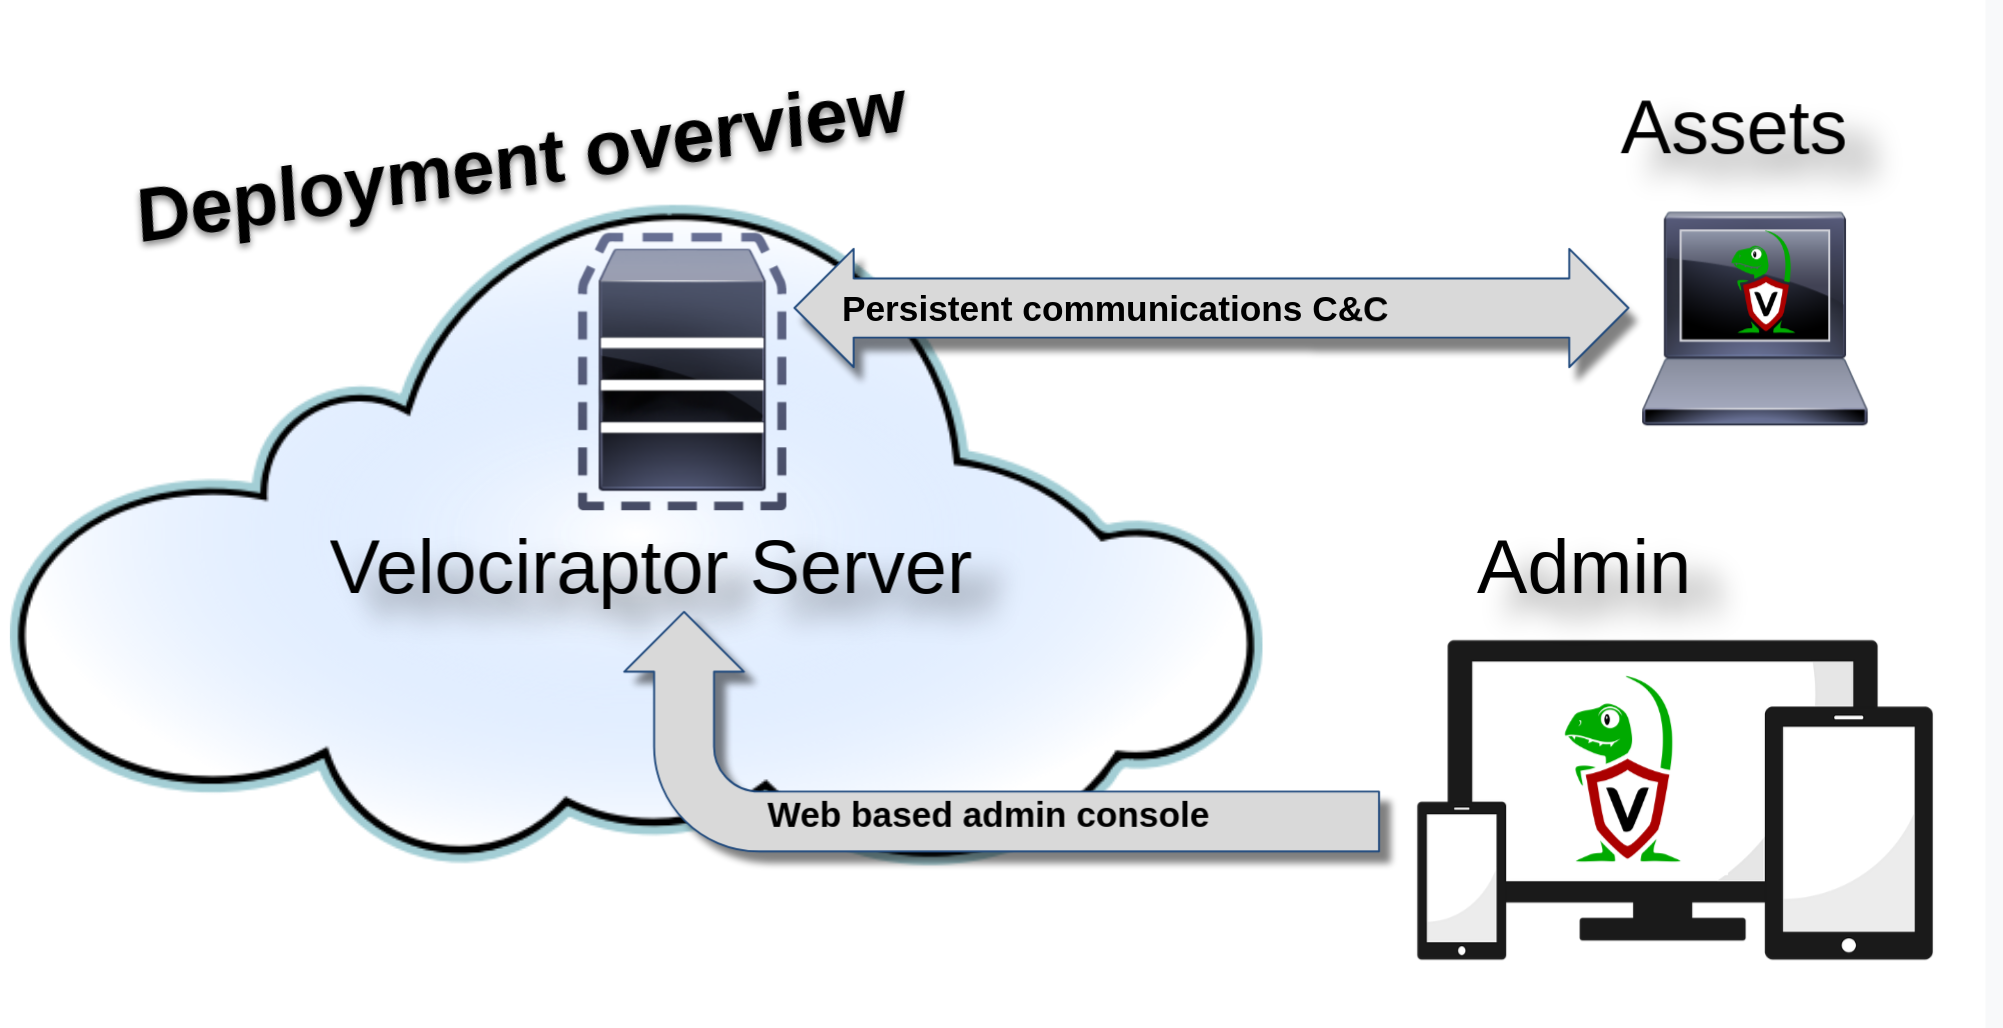

### Velociraptor server installation

1. Download velociraptor (ubuntu 22.04)
```bash
   wget download https://github.com/Velocidex/velociraptor/releases/download/v0.72/velociraptor-v0.72.3-linux-amd64
```

## Uptime Kuma
---

This is an open-source monitoring tool used to monitor the uptime of systems. We are using it to monitor the uptime of Wazuh and Grafana, if any of the platforms is down, we will know. Just like uptime robot we can also get notification alerts to alarm us if an incident has happened.

#### Uptime Kuma installation

1. run command in shell
```bash
   docker run -d --restart=always -p 3001:3001 -v uptime-kuma:/app/data --name uptime-kuma louislam/uptime-kuma:1
```